# RCNN for legend detection 

This is an adaption of [this tutorial](https://johschmidt42.medium.com/train-your-own-object-detector-with-faster-rcnn-pytorch-8d3c759cfc70).  

In [1]:
import os 
from PIL import Image 

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib.patches as patches 

import torch 
import pathlib 
from skimage.io import imread 
from torchvision.ops import box_convert 
from typing import List, Dict 
import pathlib 
import cv2 

import multiprocessing 

# Prepare data 

In [2]:
!wget https://osf.io/5fv4u/download -O bboxes.zip 
if not os.path.exists("bboxes"): 
    !unzip bboxes.zip # bounding boxes (csvs) 

!wget https://osf.io/5fv4u/download -O corpora.zip 
if not os.path.exists("corpora"): 
    !unzip bboxes

--2021-11-12 18:16:35--  https://osf.io/5fv4u/download
Resolving osf.io... 35.190.84.173
Connecting to osf.io|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/ztv7p/providers/osfstorage/618ed887fe6756000e66e9df?action=download&direct&version=1 [following]
--2021-11-12 18:16:36--  https://files.osf.io/v1/resources/ztv7p/providers/osfstorage/618ed887fe6756000e66e9df?action=download&direct&version=1
Resolving files.osf.io... 35.186.214.196
Connecting to files.osf.io|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153480316 (146M) [application/octet-stream]
Saving to: ‘bboxes.zip’

bboxes.zip          100%[===================>] 146,37M  12,0MB/s    in 13s     

2021-11-12 18:16:50 (11,1 MB/s) - ‘bboxes.zip’ saved [153480316/153480316]

--2021-11-12 18:16:50--  https://osf.io/5fv4u/download
Resolving osf.io... 35.190.84.173
Connecting to osf.io|35.190.84.173|:443... connect

In [3]:
# !wget https://osf.io/4pvqu/download -O bboxes.zip 
# !unzip bboxes.zip # bounding boxes (csvs) 

# !wget https://osf.io/5fv4u/download -O corpora.zip 
# !unzip corpora.zip # images (pngs) 

In [4]:
datapath = "corpora/" 
bboxes = "bboxes/" 

def load_data(datapath = datapath, bboxespath = bboxes, n_files = 99): 
    """ 
    Load `n_files` from `datapath`; the csv containing the 
    bounding boxes are presumably in `bboxespath`. 
    """ 
    data = {
        "filename": list(),  
        "array": list() 
    } 
    
    files = os.listdir(datapath) 
    
    for i, file in enumerate(files): 
        # if i > n_files: return data 
        try: 
            if file.endswith(".png"): 
                legbboxes = pd.read_csv(bboxespath + file.replace(".png", "-bbs.csv")) 
                data["array"].append(legbboxes) 
                data["filename"].append(file) 
        except FileNotFoundError: 
            continue 
    
    return data 

In [5]:
folders = os.listdir(datapath)  

data = {
    "filename": list(), 
    "bbox": list() 
} 
for folder in folders: 
    folder = folder + "/" 
    currdata = load_data(datapath = datapath + folder, bboxespath = bboxes + folder)      
    data["filename"] = data["filename"] + \
        [folder + "/" + filename for filename in currdata["filename"]]  
    data["bbox"] = data["bbox"] + currdata["array"]  

print("Instances:", len(data["bbox"]))  

Instances: 278


Training data


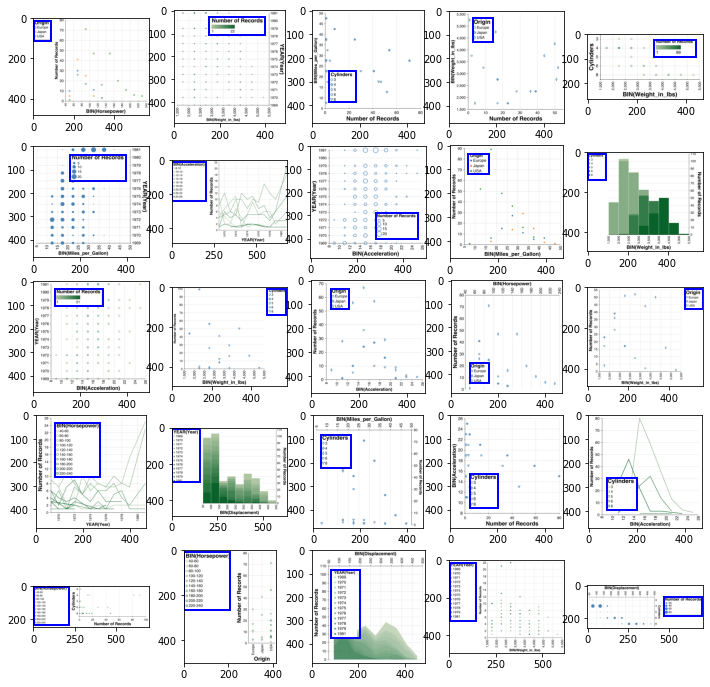

In [6]:
_, axs = plt.subplots(5, 5, figsize = (12, 12))  
axs = axs.flatten() 
naxs = axs.shape[0] 
for bbox, imgpath, ax in zip(data["bbox"][:naxs], data["filename"][:naxs], axs): 
    img = plt.imread(datapath + imgpath)
    x, y, width, height = bbox[["x", "y", "width", "height"]].to_numpy()[0] 
    rect = patches.Rectangle((x, y), width, height, linewidth = 2, 
                            facecolor = "none", edgecolor = "blue") 
    ax.imshow(img) 
    ax.add_patch(rect) 
print("Training data") 
plt.show() 

In [7]:
def reshape_data(data: dict): 
    """ 
    Reshape data `data` to be compatible with 
    PyTorch's implementation of RCNN. More precisely, 
    it will convert the dictionary `data` to another dictionary 
    with the structure 
    {
        "boxes": List[np.array], 
        "labels": List[str]
    }, 
    in which the boxes have the format `xyxy`. 
    """ 
    label = 1 
    
    ndata = {
        "boxes": list(), 
        "labels": list(), 
        "files": list() 
    }  
    
    for i, df in enumerate(data["bbox"]):  
        x, y, width, height = df[["x", "y", "width", "height"]].to_numpy()[0] 
        ndata["boxes"].append(np.array([x, y, x + width, y + height]).reshape(1, 4)) 
        ndata["labels"].append(label)         
        ndata["files"].append(datapath + data["filename"][i]) 
    return ndata 

ndata = reshape_data(data) 

# Data set compatibility with PyTorch 

In [8]:
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2 

class ChartDataset(torch.utils.data.Dataset): 
    """ 
    Generate a data set which is compatible with 
    the PyTorch functions for RCNN. For this, it needs a dictionary 
    with keys `boxes`, containing the bounding boxes, and the 
    labels. 
    """
    
    # from 
    # https://johschmidt42.medium.com/train-your-own-object-detector-with-faster-rcnn-pytorch-8d3c759cfc70
    def __init__(self, 
                data: Dict,  
                width: int = 512, 
                height: int = 512, 
                use_cache: bool = False,  
                transforms: A.Compose = None): 
        
        self.data = data 
        self.inputs = data["files"] 
        self.use_cache = use_cache 
        self.width = width 
        self.height = height 
        if self.use_cache: 
            # multiprocessing to cache images 
            from multiprocessing import Pool 
            with Pool() as pool: 
                self.cached_data = pool.starmap(self.read_images, 
                                               inputs)
    def __len__(self): 
        return len(self.inputs) 
    
    def __getitem__(self, 
                   index: int): 
        
        if self.use_cache: 
            x = self.cached_data[index] 
        else: 
            input_filename = self.inputs[index] 
            x = self.read_images(input_filename) 
            # x = x.resize((self.width, self.height), Image.ANTIALIAS) 
            x = np.array(x).astype("float32")/float(255)  
            x = x.reshape(3, *x.shape[:2]) 
        # from rgba to rgb 
        if x.shape[-1] == 4: 
            from skiimage.color import rgba2rgb 
            x = rgba2rgb(x) 
            
        # boxes 
        try: 
            boxes = torch.from_numpy(self.data["boxes"][index]).to(torch.float32) 
        except TypeError: 
            boxes = torch.tensor(self.data["boxes"][index]).to(torch.float32) 
            
        # labels 
        labels = self.data["labels"][index]
        
        # labels to tensor 
        try: 
            labels = torch.from_numpy(labels).to(torch.int64) 
        except TypeError: 
            labels = torch.tensor(labels).to(torch.int64) 
            
        target = { 
            "image": x,  
            "bboxes": boxes, 
            "labels": labels.reshape(1) 
        } 
        
        return {
            "x": torch.from_numpy(target["image"]), 
            "y": {
                "boxes": target["bboxes"], 
                "labels": target["labels"] 
            } 
        }
    
    @staticmethod 
    def read_images(inp): 
        # img = cv2.imread(inp) 
        return Image.open(inp) 
    

In [9]:
dataset = ChartDataset(ndata, 
                      width = 512, 
                      height = 512) 

# Data loader

In [10]:
def collate_double(batch): 
    """ 
    Collate function for the ChartDataset, designed to 
    be used with PyTorch's DataLoader.  
    """ 
    x = [sample["x"] for sample in batch] 
    y = [sample["y"] for sample in batch] 
    
    for i, box in enumerate(y): 
        if isinstance(box["boxes"], np.ndarray): 
            y[i]["boxes"] = torch.from_numpy(box["boxes"]) 
        elif not isinstance(box["boxes"], torch.Tensor): 
            y[i]["boxes"] = torch.tensor(box["boxes"])  
    
    return x, y 

from torch.utils.data import DataLoader 

dataloader = DataLoader(dataset = dataset, 
                       batch_size = 2, 
                       shuffle = True, 
                       collate_fn = collate_double) 

In [11]:
from itertools import chain 
import pytorch_lightning as pl 
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2 

class RCNN(pl.LightningModule): 
    
    def __init__(self, 
                model: torch.nn.Module, 
                lr: float = .0001, 
                iou_threshold: float = .5): 
        
        super().__init__() 
        
        self.model = model 
        # (background is a class) 
        self.num_classes = self.model.num_classes 
        
        self.lr = lr 
        self.iou_threshold = iou_threshold 
        
        self.mu = model.image_mean 
        self.sigma = model.image_std 
        self.min_size = model.min_size, 
        self.max_size = model.max_size 
        
        # save hyperparameters 
        self.save_hyperparameters() 
        
    def forward(self, x): 
        self.model.eval() 
        return self.model(x) 
    
    def training_step(self, batch, batch_idx): 
        x, y = batch 
        
        loss_func = self.model(x, y) 
        loss = sum(loss for loss in loss_func.values()) 
        
        self.log_dict(loss_func) 
        return loss 
    
    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        
        preds = self.model(x) 
        
        gt_boxes = [box["boxes"] for box in y]
        gt_boxes = list(chain(*gt_boxes)) 
        
        pred_boxes = preds 
        pred_boxes = list(chain(*pred_boxes)) 
        
        return {"pred_boxes": pred_boxes, 
               "gt_boxes": gt_boxes} 
    
    def validation_epoch_end(self, boxes, message = "Validation"): 
        gt_boxes = [box["gt_boxes"] for box in boxes] 
        gt_boxes = list(chain(*gt_boxes)) 
        pred_boxes = [box["pred_boxes"] for box in boxes] 
        pred_boxes = list(chain(*pred_boxes)) 
        
        from metrics.pascal_voc_evaluator import get_pascalvoc_metrics 
        from metrics.enumerators import MethodAveragePrecision 
        
        metric = get_pascalvoc_metrics(gt_boxes = gt_boxes, 
                                      det_boxes = pred_boxes, 
                                      iou_threshold = self.iou_threshold, 
                                      method = MethodAveragePrecision.EVERY_POINT_INTERPOLATION, 
                                      generate_table = True) 
        
        
        per_class, mAP = metric["per_class"], metric["mAP"] 
        self.log(f"{message} mAP", mAP) 
        
        for key, value in per_class.items(): 
            self.log(f"{message} for class {key}", value["AP"]) 
            
    def test_step(self, batch, batch_idx): 
        x, y = batch 
        
        preds = self.model(x) 
        
        gt_boxes = y["boxes"] 
        gt_boxes = list(chain(*gt_boxes)) 
        
        pred_boxes = preds 
        pred_boxes = list(chain(*pred_boxes)) 
        
        return {
            "pred_boxes": pred_boxes, 
            "gt_boxes": gt_boxes 
        } 
    
    def test_epoch_end(self, boxes): 
        return self.validation_epoch_end(boxes, message = "Test") 
    
    def configure_optimizers(self): 
        optimizer = torch.optim.SGD(self.model.parameters(), 
                                   lr = self.lr, 
                                   momentum = .99, 
                                   weight_decay = .005) 
        
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode = "max", 
            factor = .75, 
            patience = 29   
        ) 
        return {
            "optimizer": optimizer, 
            "lr_scheduler": lr_scheduler, 
            "monitor": "loss_box_reg" 
        } 
    

# Partition and instantiate data set

In [12]:
def split_dataset(boxes: np.array,  
                  labels: np.array, 
                  files: np.array, 
                 train: float = .8, 
                  test: float = .2, shuffle = True): 
    """ 
    Split the data set; `train` of it will be used for training; 
    `test`, for test; and the rest, for validation. Also, if 
    `shuffle` is true, then the data set will be randomly 
    permurted for the partition. 
    """ 
    
    assert len(boxes) == len(labels) and len(boxes) == len(files) 
    
    if shuffle: 
        permutation = np.random.permutation(len(boxes)) 
        boxes = boxes[permutation] 
        labels = labels[permutation] 
        files = files[permutation]  
        # np.random.shuffle(data) 
    
    # if train + test >= 1: 
    #    raise ValueError("`train` + `test` < 1") 
    
    size = len(boxes) 
    
    train_size = int(np.floor(size * train))  
    test_size = int(np.floor(size * test)) 
    validation_size = size - train_size - test_size 
    
    
    train_files = files[:train_size] 
    test_files = files[train_size:(train_size + test_size)] 
    validation_files = files[(train_size + test_size):] 
    
    train = {
        "boxes": boxes[:train_size], 
        "labels": labels[:train_size], 
        "files": train_files 
    } 
    
    test = {
        "boxes": boxes[train_size:(train_size + test_size)], 
        "labels": labels[train_size:(train_size + test_size)], 
        "files": test_files 
    } 
    
    validation = {
        "boxes": boxes[(train_size + test_size):], 
        "labels": labels[(train_size + test_size):], 
        "files": validation_files 
    } 
     
    return train, test, validation 

In [13]:
def draw_rectangle(img, x, y, width, height): 
    """ 
    Draw a rectangle in the image `img`; it uses 
    `patches` from matplotlib. 
    """ 
    ax = plt.gca() # current axis 
    rect = patches.Rectangle((x, y), width, height, linewidth = 2, 
                             facecolor = "none", edgecolor = "blue") 
    ax.imshow(img) 
    ax.add_patch(rect) 
    plt.show()

In [14]:
params = {
    "BATCH_SIZE": 2, 
    "LR": .001, 
    "CLASSES": 2, 
    "SEED": 42, 
    "PRECISION": 32, 
    "PROJECT": "chart", 
    "EXPERIMENT": "color", 
    "MAXEPOCHS": 500, 
    "BACKBONE": "resnet34", 
    "FPN": False, 
    "ANCHOR_SIZE": ((32,64,128,256,512),), 
    "ASPECT_RATIOS": ((.05, 1, 2),), 
    "MIN_SIZE": 512, 
    "MAX_SIZE": 512, 
    "IMG_MEAN": [.485, .456, .406], 
    "IMG_STD": [.229, .224, .225], 
    "IOU_THRESHOLD": .5 
} 

np.random.seed(params["SEED"]) 

train, test, validation = split_dataset(np.array(ndata["boxes"]), 
                                        np.array(ndata["labels"]), 
                                        np.array(ndata["files"]))   

In [15]:
dataset_train = ChartDataset(train)  

dataset_test = ChartDataset(test) 

dataloader_train = DataLoader(dataset = dataset_train, 
                             batch_size = params["BATCH_SIZE"], 
                             shuffle = True, 
                             num_workers = multiprocessing.cpu_count(), 
                             collate_fn = collate_double) 

dataloader_test = DataLoader(dataset = dataset_test, 
                            batch_size = 1, 
                            shuffle = False, 
                            collate_fn = collate_double)  

# Instantiate model 

In [16]:
from torchvision.models.detection.faster_rcnn import FasterRCNN 
from torchvision.models.detection.rpn import AnchorGenerator 
from torchvision.ops import MultiScaleRoIAlign 
import torchvision.models as models 

from collections import OrderedDict 

def get_RCNN(
    backbone: torch.nn.Module, 
    anchor_generator: AnchorGenerator, 
    roi_pooler: MultiScaleRoIAlign, 
    num_classes: int, 
    image_mean: List[float] = params["IMG_MEAN"], 
    image_std: List[float] = params["IMG_STD"], 
    min_size: int = params["MIN_SIZE"], 
    max_size: int = params["MAX_SIZE"], 
    **kwargs 
): 
    """ 
    Instantiate the model. 
    """ 
    
    model = FasterRCNN(
        backbone = backbone, 
        rpn_anchor_generator = anchor_generator, 
        box_roi_pool = roi_pooler, 
        num_classes = num_classes, 
        image_mean = image_mean, 
        image_std = image_std, 
        min_size = min_size, 
        max_size = max_size, 
        **kwargs 
    ) 
    
    model.num_classes = num_classes 
    model.image_mean = image_mean 
    model.image_std = image_std 
    model.min_size = min_size 
    model.max_size = max_size 
    
    return model 

def get_RCNN_resnet(
    num_classes: int, 
    backbone_name: str, 
    anchor_size: List[float], 
    aspect_ratios: List[float], 
    min_size: int = 256, 
    max_size: int = 512, 
    **kwargs, 
): 
    """ 
    Instantiate an RCNN model with ResNet backbone. 
    """ 
    
    backbone = getattr(models, backbone_name)(pretrained = True) 
    backbone = torch.nn.Sequential(*list(backbone.children())[:-2]) 
    backbone.out_channels = 512 
    
    aspect_ratios = aspect_ratios * len(anchor_size) 
    anchor_generator = AnchorGenerator(sizes = anchor_size, 
                                        aspect_ratios = aspect_ratios) 
        
    # ROI pool 
    with torch.no_grad(): 
        backbone.eval() 
        random_input = torch.rand(size = (1, 3, 512, 512)) 
        features = backbone(random_input) 
        
    if isinstance(features, torch.Tensor): 
        features = OrderedDict([("0", features)]) 
    
    featmap_names = [key for key in features.keys() if key.isnumeric()] 
    
    roi_pool = MultiScaleRoIAlign(
        featmap_names = featmap_names, 
        output_size = 7, 
        sampling_ratio = 2 
    ) 
    

    return get_RCNN(
        backbone = backbone, 
        anchor_generator = anchor_generator, 
        roi_pooler = roi_pool, 
        num_classes = num_classes, 
        min_size = min_size, 
        max_size = max_size, 
        **kwargs, 
    ) 
    
    # return backbone  

In [17]:
model = get_RCNN_resnet(
    num_classes = params["CLASSES"], 
    backbone_name = params["BACKBONE"], 
    anchor_size = params["ANCHOR_SIZE"], 
    aspect_ratios = params["ASPECT_RATIOS"], 
    min_size = params["MIN_SIZE"], 
    max_size = params["MAX_SIZE"],  
) 

In [18]:
task = RCNN(
    model = model, 
    lr = params["LR"], 
    iou_threshold = params["IOU_THRESHOLD"] 
) 

# Training

In [19]:
from pytorch_lightning.callbacks import (
    ModelCheckpoint, 
    LearningRateMonitor, 
    EarlyStopping 
) 

checkpoint_callback = ModelCheckpoint(monitor = "loss_box_reg", mode = "min") 
learningrate_callback = LearningRateMonitor(logging_interval = "step", 
                                           log_momentum = False) 
early_stopping_callback = EarlyStopping(monitor = "loss_box_reg", patience = 50, 
                                       mode = "min") 

from pytorch_lightning import Trainer 

trainer = Trainer(
    gpus = None, 
    precision = params["PRECISION"], 
    callbacks = [
        checkpoint_callback, 
        learningrate_callback, 
        early_stopping_callback
    ], 
    default_root_dir = "labels", 
    # logger = tb_logger, # inappropriate behaviour 
    log_every_n_steps = 1, 
    num_sanity_val_steps = 0, 
    max_epochs = params["MAXEPOCHS"] 
) 

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tiago/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1303: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


In [20]:
# trainer.fit(
#     task, 
#     train_dataloaders = dataloader_train, 
#     # val_dataloaders = dataloader_validation 
# ) 

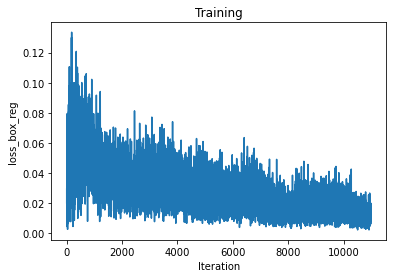

In [24]:
# Plot loss during training 
y = np.genfromtxt("model.csv")[1:] 
x = np.arange(y.shape[0]) 

plt.plot(x, y) 
plt.xlabel("Iteration") 
plt.ylabel("loss_box_reg") 
plt.title("Training") 

plt.show() 

# Test model

In [21]:
test_files = test["files"] 
train_files = train["files"] 
model_path = "sample.pt"
checkpoint = torch.load(model_path)
model_state_dict = checkpoint["hyper_parameters"]["model"]

In [22]:
model_state = model_state_dict.state_dict() 
model.load_state_dict(model_state) 
model = model.eval() 

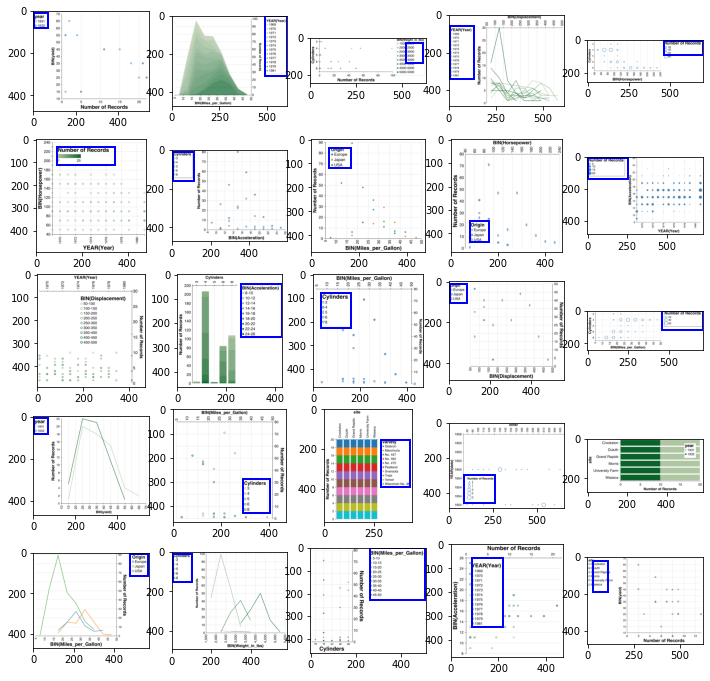

In [23]:
test_files = test["files"] 

_, axs = plt.subplots(5, 5, figsize = (12, 12))  
axs = axs.flatten()
naxs = len(axs) 
for file, ax in zip(test_files[:naxs], axs[:naxs]): 
    with torch.no_grad(): 
        img = torch.from_numpy(plt.imread(file)) 
        # Reshape image 
        img = img.reshape(3, *img.shape[:2])   
        prediction = model([img]) 
        
        rect = None 
        
        if len(prediction[0]["boxes"]) > 0: 
            bbox = prediction[0]["boxes"][0] 
            x, y = bbox[0], bbox[1] 
            width, height = bbox[2] - x, bbox[3] - y 
            rect = patches.Rectangle((x, y), width, height, 
                                    facecolor = "none", 
                                    edgecolor = "blue", 
                                    linewidth = 2) 
        ax.imshow(img.reshape(*img.shape[1:], 3)) 
        if rect: ax.add_patch(rect) 
plt.show() 